In [59]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

In [60]:
import os

base_path = "/kaggle/input/data-science-bowl-2018-competition-merged-mask/data science bowl 2018/stage1_train 2"

print("Total Samples:", len(os.listdir(base_path)))

Total Samples: 670


In [61]:
def compute_metrics(gt, pred):
    gt = gt.flatten()
    pred = pred.flatten()

    tn, fp, fn, tp = confusion_matrix(gt, pred, labels=[0,1]).ravel()

    sensitivity = tp / (tp + fn + 1e-8)
    specificity = tn / (tn + fp + 1e-8)
    accuracy    = (tp + tn) / (tp + tn + fp + fn + 1e-8)
    dice        = (2 * tp) / (2 * tp + fp + fn + 1e-8)

    return sensitivity, specificity, accuracy, dice

In [62]:
def watershed_without_markers(img):

    img_blur = cv2.GaussianBlur(img, (5,5), 0)

    _, thresh = cv2.threshold(
        img_blur, 0, 255,
        cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
    )

    kernel = np.ones((3,3), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)

    dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)

    _, sure_fg = cv2.threshold(dist, 0.3 * dist.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)

    unknown = cv2.subtract(thresh, sure_fg)

    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    markers = cv2.watershed(img_color, markers)

    pred = np.zeros_like(img)
    pred[markers > 1] = 1

    return pred

In [63]:
def watershed_with_markers(img):

    # 1. Smooth
    img_blur = cv2.GaussianBlur(img, (5,5), 0)

    # 2. Laplacian to highlight dark nuclei centers
    lap = cv2.Laplacian(img_blur, cv2.CV_64F)
    lap = np.uint8(np.absolute(lap))

    # 3. Otsu threshold on Laplacian
    _, thresh = cv2.threshold(lap, 0, 255,
                              cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN,
                               kernel, iterations=1)

    # Distance transform
    dist = cv2.distanceTransform(opening, cv2.DIST_L2, 5)

    _, sure_fg = cv2.threshold(dist, 0.4 * dist.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)

    sure_bg = cv2.dilate(opening, kernel, iterations=2)
    unknown = cv2.subtract(sure_bg, sure_fg)

    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    markers = cv2.watershed(img_color, markers)

    pred = np.zeros_like(img)
    pred[markers > 1] = 1

    return pred

In [64]:
from tqdm import tqdm

no_marker_results = []
marker_results = []

folders = sorted(os.listdir(base_path))

for folder in tqdm(folders):

    folder_path = os.path.join(base_path, folder)

    img_dir = os.path.join(folder_path, "images")
    mask_dir = os.path.join(folder_path, "masks")

    img_name = os.listdir(img_dir)[0]
    img_path = os.path.join(img_dir, img_name)

    img = cv2.imread(img_path, 0)

    gt_mask = np.zeros_like(img)
    for m in os.listdir(mask_dir):
        m_img = cv2.imread(os.path.join(mask_dir, m), 0)
        gt_mask = np.maximum(gt_mask, m_img)

    gt_mask = (gt_mask > 0).astype(np.uint8)

    pred_nm = watershed_without_markers(img)
    pred_m  = watershed_with_markers(img)

    no_marker_results.append(compute_metrics(gt_mask, pred_nm))
    marker_results.append(compute_metrics(gt_mask, pred_m))

100%|██████████| 670/670 [01:33<00:00,  7.14it/s]


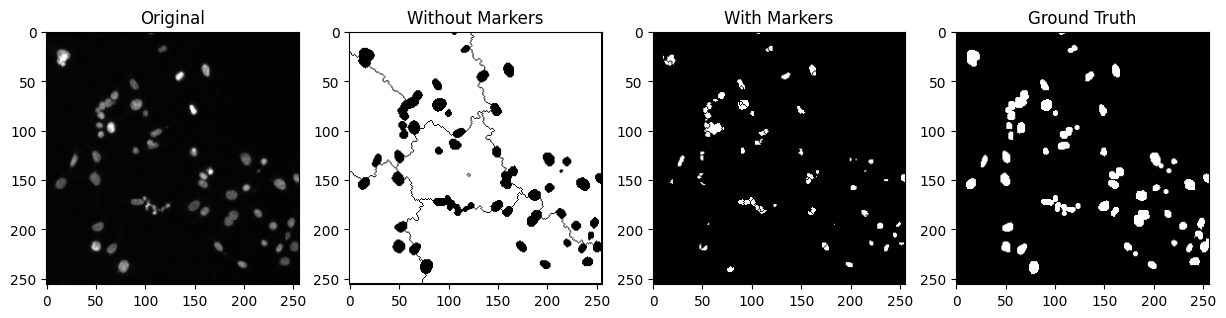

In [65]:
index = 26

folder = folders[index]
folder_path = os.path.join(base_path, folder)

img_path = os.path.join(folder_path, "images",
                        os.listdir(os.path.join(folder_path,"images"))[0])
mask_dir = os.path.join(folder_path, "masks")

img = cv2.imread(img_path, 0)

# Combine masks
gt_mask = np.zeros_like(img)
for m in os.listdir(mask_dir):
    m_img = cv2.imread(os.path.join(mask_dir, m), 0)
    gt_mask = np.maximum(gt_mask, m_img)

gt_mask = (gt_mask > 0).astype(np.uint8)

pred_nm = watershed_without_markers(img)
pred_m  = watershed_with_markers(img)

plt.figure(figsize=(15,4))

plt.subplot(1,4,1)
plt.imshow(img, cmap='gray')
plt.title("Original")

plt.subplot(1,4,2)
plt.imshow(pred_nm, cmap='gray')
plt.title("Without Markers")

plt.subplot(1,4,3)
plt.imshow(pred_m, cmap='gray')
plt.title("With Markers")

plt.subplot(1,4,4)
plt.imshow(gt_mask, cmap='gray')
plt.title("Ground Truth")

plt.show()

In [66]:
no_marker_results = np.array(no_marker_results)
marker_results = np.array(marker_results)

results = pd.DataFrame({
    "Metric": ["Sensitivity", "Specificity", "Accuracy", "Dice"],
    "Without Markers": np.mean(no_marker_results, axis=0),
    "With Markers": np.mean(marker_results, axis=0)
})

results

,Metric,Without Markers,With Markers
0,Sensitivity,0.161548,0.253630
1,Specificity,0.214941,0.984184
2,Accuracy,0.205215,0.875394
3,Dice,0.138431,0.338647


**Conclusion**:

The watershed algorithm was implemented to separate cell nuclei in microscopy images, and its performance was evaluated with and without marker control.

The basic watershed method (without markers) resulted in severe over-segmentation and inaccurate region flooding. This led to low sensitivity, low Dice score, and poor overall accuracy, as large background or cytoplasm regions were incorrectly segmented as nuclei.

In contrast, the marker-controlled watershed approach significantly improved segmentation quality. By using distance transform-based foreground markers, the flooding process was constrained, reducing false boundaries and improving object separation. This resulted in:

Higher Dice score

Improved sensitivity

Dramatically improved specificity

Much better overall accuracy

Although the classical watershed method does not achieve very high Dice scores on the Data Science Bowl dataset (which is highly complex and variable), marker control clearly enhances segmentation stability and reduces over-segmentation.

Therefore, marker-controlled watershed provides better nuclei separation compared to the basic watershed approach, especially in controlling region merging and limiting segmentation errors.